In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/learning-agency-lab-automated-essay-scoring-2/sample_submission.csv
/kaggle/input/learning-agency-lab-automated-essay-scoring-2/train.csv
/kaggle/input/learning-agency-lab-automated-essay-scoring-2/test.csv


import other libraries

In [2]:
!pip install mord

  Preparing metadata (setup.py) ... - done
  Created wheel for mord: filename=mord-0.7-py3-none-any.whl size=9886 sha256=462970b4e5f924d6078616af276e4429be68ead1b65e1543a359d78816ce0aa6
  Stored in directory: /root/.cache/pip/wheels/77/00/19/3cea86fbfc737ec4acb515cd94497dcc33f943fa157548b96c
Successfully built mord


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import cohen_kappa_score, make_scorer, classification_report, accuracy_score, confusion_matrix
import re
from sklearn.pipeline import Pipeline
# from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler, FunctionTransformer

from gensim.models import Word2Vec
from mord import OrdinalRidge
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS

# import statsmodels.api as sm
# from statsmodels.miscmodels.ordinal_model import OrderedModel

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Read in the dataset

In [4]:
df_train = pd.read_csv('/kaggle/input/learning-agency-lab-automated-essay-scoring-2/train.csv')
df_test = pd.read_csv('/kaggle/input/learning-agency-lab-automated-essay-scoring-2/test.csv')
df_sub = pd.read_csv('/kaggle/input/learning-agency-lab-automated-essay-scoring-2/sample_submission.csv')

Data cleaning

In [5]:
def removeHTML(x):
    html=re.compile(r'<.*?>')
    return html.sub(r'',x)

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"\xa0"," ",phrase)
    return phrase.strip()

def clean_text(x):
    # Convert words to lowercase
    x = x.lower()
    # Remove HTML
    x = removeHTML(x)
    # Delete strings starting with @
    x = re.sub("@\w+", '',x)
    # Delete Numbers
    x = re.sub("'\d+", '',x)
    x = re.sub("\d+", '',x)
    # Delete URL
    x = re.sub("http\w+", '',x)
    # Replace consecutive empty spaces with a single space character
    x = re.sub(r"\s+", " ", x)
    # Replace consecutive commas and periods with one comma and period character
    x = re.sub(r"\.+", ".", x)
    x = re.sub(r"\,+", ",", x)
    # Remove empty characters at the beginning and end
    x = x.strip()
    return decontracted(x)

In [6]:
df_train['full_text'] = df_train['full_text'].apply(clean_text)
df_test['full_text'] = df_test['full_text'].apply(clean_text)


In [7]:
df_train['full_text'][0]

'many people have car where they live. the thing they do not know is that when you use a car alot of thing can happen like you can get in accidet or the smoke that the car has is bad to breath on if someone is walk but in vauban,germany they dont have that proble because percent of vauban is families do not own cars,and percent sold a car to move there. street parkig ,driveways and home garages are forbidden on the outskirts of freiburd that near the french and swiss borders. you probaly will not see a car in vauban is streets because they are completely "car free" but if some that lives in vauban that owns a car ownership is allowed,but there are only two places that you can park a large garages at the edge of the development,where a car owner buys a space but it not cheap to buy one they sell the space for you car for $, along with a home. the vauban people completed this in ,they said that this an example of a growing trend in europe,the untile states and some where else are suburba

feature extraction - maybe add in more features like bag of words/ keywords?

create a word_count and text length column

In [8]:
df_train['word_count'] = df_train["full_text"].str.split().str.len()
df_test['word_count'] = df_test["full_text"].str.split().str.len()

In [9]:
df_train['length'] = df_train["full_text"].str.len()
df_test['length'] = df_test["full_text"].str.len()

In [10]:
df_train.head()

,essay_id,full_text,score,word_count,length
0,000d118,many people have car where they live. the thin...,3,496,2647
1,000fe60,i am a scientist at nasa that is discussing th...,3,336,1668
2,001ab80,people always wish they had the same technolog...,4,553,3068
3,001bdc0,"we all heard about venus, the planet without a...",4,450,2679
4,002ba53,"dear, state senator this is a letter to argue ...",3,377,2188


attempt at creating vector embeddings:

In [11]:
word2vec_model = Word2Vec(df_train['full_text'], 
                          vector_size=100,
                          min_count=1,
                          window=5, 
                          )

In [12]:
def vectorize_text(text, word2vec_model):
    text_vector = np.zeros(100)  # Initialize a vector of zeros (100-dimensional)
    for word in text.split():  # Split text into words
        if word in word2vec_model.wv:  # Check if word is in the vocabulary
            text_vector += word2vec_model.wv[word]  # Add word vector to the text vector
    return text_vector

In [13]:
# Apply the vectorize_text function to each text entry in train_df['full_text']
df_train['text_vector'] = df_train['full_text'].apply(lambda x: vectorize_text(x, word2vec_model))
df_test['text_vector'] = df_test['full_text'].apply(lambda x: vectorize_text(x, word2vec_model))


In [14]:
df_train.head()

,essay_id,full_text,score,word_count,length,text_vector
0,000d118,many people have car where they live. the thin...,3,496,2647,"[2.801115781068802, 5.065545415505767, -6.8037..."
1,000fe60,i am a scientist at nasa that is discussing th...,3,336,1668,"[1.549383521080017, 4.427499245852232, -7.5442..."
2,001ab80,people always wish they had the same technolog...,4,553,3068,"[2.65594045817852, 2.9395769238471985, -4.1838..."
3,001bdc0,"we all heard about venus, the planet without a...",4,450,2679,"[3.981909215450287, 5.240687817335129, -4.9689..."
4,002ba53,"dear, state senator this is a letter to argue ...",3,377,2188,"[1.9554996713995934, 3.9430476184934378, -7.30..."


In [15]:
# X_train = df_train['full_text']
# y_train = df_train['score']
# X_test = df_test['full_text']
# y_test = df_sub['score']

this method trains and evaluates each pipeline 
returns the y_pred and quadratic weighted kappa score of the model

In [16]:
def train_and_evaluate_pipeline(pipeline, X_train, y_train, X_test, y_test):
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    kappa = cohen_kappa_score(y_test, y_pred, weights='quadratic')
    
    print()
    print('Classifier used: ', pipeline.named_steps['classifier'])
    print('y_test: ', y_test.tolist()[0:10])
    print('y_pred: ', y_pred.tolist()[0:10])
    print('quadratic weighted kappa score: ', kappa)
    
    return pipeline, y_pred

method for performing cross_validation of pipelines and showing their average performances

In [17]:
#define quadratic weighted kappa as a custom scorer
qwk_scorer = make_scorer(cohen_kappa_score, weights='quadratic')

def pipeline_cross_validation(pipeline, X_train, y_train, qwk_scorer=qwk_scorer):
    # Define cross-validation strategy and perform cross-validation
    scoring = {'accuracy': 'accuracy', 'f1_weighted': 'f1_weighted', 'qwk': qwk_scorer}
    cv_results = cross_validate(pipeline, X_train, y_train, cv=5, scoring=scoring)

    # Print cross-validation results
    print("Mean Accuracy:", np.mean(cv_results['test_accuracy']))
    print("Mean Weighted F1-score:", np.mean(cv_results['test_f1_weighted']))
    print("Mean Quadratic Weighted Kappa Score:", np.mean(cv_results['test_qwk']))
    
#     return np.mean(cv_results['test_qwk']), np.mean(cv_results['test_accuracy']), np.mean(cv_results['test_f1_weighted'])
    return cv_results

method for printing wordcloud

In [18]:
def print_cloud(data):
    text = " ".join(word for word in data)
    print ("There are {} words in the combination".format(len(text)))
    stopwords_set = set(stopwords.words('english'))
    wordcloud = WordCloud(stopwords=stopwords_set, background_color="white").generate(text)
    return wordcloud

show word cloud for full texts of essays

There are 35362071 words in the combination


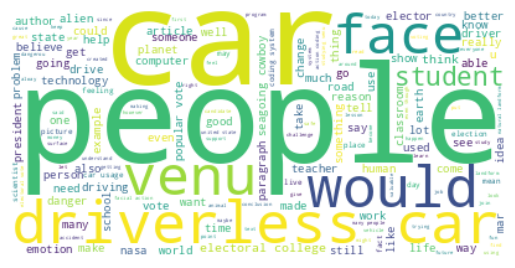

In [19]:
wordcloud = print_cloud(df_train['full_text'])
fig = plt.figure(2)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

create the tfidf

In [20]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', min_df=0.05, max_df=0.95,)
# tfidf = tfidf_vectorizer.fit_transform(X_train)


create the multinomial logistic regression classifier

In [21]:
logreg_clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500)

create a pipeline for logistic regression classifier

In [22]:
# Define a transformer to extract 'text_vector' from DataFrame
def get_text_vector(df):
    return np.vstack(df['text_vector'])

In [23]:
tfidf_preprocessor = ColumnTransformer(
    transformers=[
        ('text', tfidf_vectorizer, 'full_text'),
        ('word_count', StandardScaler(), ['word_count']),
        ('length', StandardScaler(), ['length'])
    ],
    remainder='passthrough'
)

w2v_preprocessor = ColumnTransformer(
    transformers=[
#         ('text', tfidf_vectorizer, 'full_text'),
        ('text_vector', FunctionTransformer(get_text_vector, validate=False), ['text_vector']),
        ('word_count', StandardScaler(), ['word_count']),
        ('length', StandardScaler(), ['length'])
    ],
    remainder='passthrough'
)

In [24]:
logreg_pipeline = Pipeline(steps=[
#     ('tfidf', tfidf_vectorizer),
    ('preprocessor', tfidf_preprocessor),
    ('classifier', logreg_clf)
])

w2v_logreg_pipeline = Pipeline(steps=[
    ('preprocessor', w2v_preprocessor),
    ('classifier', logreg_clf)
])

fit and make a prediction

In [25]:
# df_sub['essay_id'].tolist()
# df_train.loc[(df_train['essay_id'] == '000d118') | (df_train['essay_id'] =='000fe60') | (df_train['essay_id'] =='001ab80')]
# sub_df_data = df_train.loc[(df_train['essay_id'] == '000d118') | (df_train['essay_id'] =='000fe60') | (df_train['essay_id'] =='001ab80')]
# X_test3 = tfidf_vectorizer.transform(df_test['full_text'])

In [26]:
X = df_train[['full_text', 'word_count', 'length']]
# X = df_train['full_text']
y = df_train['score']
sub_X = df_test[['full_text', 'word_count', 'length']]
sub_y = df_sub['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8)

X2 = df_train[['word_count', 'length', 'text_vector']]
sub_X2 = df_test[['word_count', 'length', 'text_vector']]

# X2 = np.array(df_train['text_vector'].tolist())
# sub_X2 = np.array(df_test['text_vector'].tolist())

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y, train_size = 0.8)


# trained_logreg_pipeline, logreg_y_pred = train_and_evaluate_pipeline(logreg_pipeline, X_train, y_train, X_test, y_test)

In [27]:
trained_logreg_pipeline, logreg_y_pred = train_and_evaluate_pipeline(logreg_pipeline, X_train, y_train, X_test, y_test)


Classifier used:  LogisticRegression(max_iter=500, multi_class='multinomial')
y_test:  [4, 2, 4, 2, 3, 4, 3, 3, 3, 1]
y_pred:  [4, 2, 4, 2, 3, 4, 3, 4, 4, 4]
quadratic weighted kappa score:  0.7362076167485437


run cross validation to get average performance

In [28]:
logreg_cv_results = pipeline_cross_validation(logreg_pipeline, X_train, y_train)
avg_logreg_qwk = np.mean(logreg_cv_results['test_qwk'])
avg_logreg_acc = np.mean(logreg_cv_results['test_accuracy'])
avg_logreg_f1 = np.mean(logreg_cv_results['test_f1_weighted'])

Mean Accuracy: 0.5888046226074396
Mean Weighted F1-score: 0.5780841704312983
Mean Quadratic Weighted Kappa Score: 0.7173891035934895


commented off just to make the notebook save and rerun properly, need to use a different clf if plan to keep

In [29]:
# trained_logreg_pipeline2, logreg_y_pred2 = train_and_evaluate_pipeline(w2v_logreg_pipeline, X_train2, y_train2, X_test2, y_test2)

In [30]:
print(classification_report(y_test, logreg_y_pred))

              precision    recall  f1-score   support

           1       0.66      0.24      0.35       279
           2       0.62      0.70      0.66       918
           3       0.58      0.69      0.63      1232
           4       0.59      0.55      0.57       790
           5       0.48      0.29      0.36       199
           6       0.62      0.18      0.28        44

    accuracy                           0.60      3462
   macro avg       0.59      0.44      0.48      3462
weighted avg       0.60      0.60      0.58      3462



In [31]:
print("Model prediction on submission essays: ", trained_logreg_pipeline.predict(sub_X).tolist())
print('Submission essays actual classes: ', sub_y.tolist())

Model prediction on submission essays:  [3, 3, 4]
Submission essays actual classes:  [3, 3, 4]


create a lightgbm model pipeline

lgbm over xgboost for performance and scalability? maybe elaborate more

In [32]:
lgbm_clf = LGBMClassifier(objective='multiclass', num_class=6, metric='multi_logloss', num_leaves=31, learning_rate=0.1, feature_fraction=0.6)

In [33]:
lgbm_pipeline = Pipeline(steps=[
#     ('tfidf', tfidf_vectorizer),   # TF-IDF Vectorizer
    ('preprocessor', tfidf_preprocessor),
    ('classifier', lgbm_clf) # LightGBM Classifier
])

use some GridSearchCV to find the best parameters

In [34]:
# parameter grid used for the grid search:
param_grid = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.05, 0.1, 0.2],
    'feature_fraction': [0.6, 0.8, 0.9]
}

In [35]:
# # create and fit the gridsearch
# grid_search = GridSearchCV(estimator=lgbm_clf, param_grid=param_grid, cv=3, scoring=qwk_scorer)
# grid_search.fit(tfidf_vectorizer.fit_transform(X_train), y_train)

# # Print the best parameters and best score
# print("Best Parameters: ", grid_search.best_params_)
# print("Best Score (quadratic weighted kappa score): ", grid_search.best_score_)

In [36]:
trained_lgbm_pipeline, lgbm_y_pred = train_and_evaluate_pipeline(lgbm_pipeline, X_train, y_train, X_test, y_test)

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053665 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 112291
[LightGBM] [Info] Number of data points in the train set: 13845, number of used features: 443
[LightGBM] [Info] Start training from score -2.655295
[LightGBM] [Info] Start training from score -1.291608
[LightGBM] [Info] Start training from score -1.008932
[LightGBM] [Info] Start training from score -1.484976
[LightGBM] [Info] Start training from score -2.887991
[LightGBM] [Info] Start training from score -4.817181
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6

Classifier 

In [37]:
lgbm_cv_results = pipeline_cross_validation(lgbm_pipeline, X_train, y_train)
avg_lgbm_qwk = np.mean(lgbm_cv_results['test_qwk'])
avg_lgbm_acc = np.mean(lgbm_cv_results['test_accuracy'])
avg_lgbm_f1 = np.mean(lgbm_cv_results['test_f1_weighted'])

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062392 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 106710
[LightGBM] [Info] Number of data points in the train set: 11076, number of used features: 442
[LightGBM] [Info] Start training from score -2.654525
[LightGBM] [Info] Start training from score -1.291608
[LightGBM] [Info] Start training from score -1.009031
[LightGBM] [Info] Start training from score -1.484896
[LightGBM] [Info] Start training from score -2.889289
[LightGBM] [Info] Start training from score -4.812726
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

In [38]:
print(classification_report(y_test, lgbm_y_pred))

              precision    recall  f1-score   support

           1       0.66      0.27      0.39       279
           2       0.65      0.65      0.65       918
           3       0.59      0.68      0.63      1232
           4       0.56      0.60      0.58       790
           5       0.47      0.37      0.41       199
           6       0.54      0.16      0.25        44

    accuracy                           0.60      3462
   macro avg       0.58      0.45      0.48      3462
weighted avg       0.60      0.60      0.59      3462



In [39]:
# trained_lgbm_pipeline.predict(df_test[['full_text', 'word_count', 'length']]).tolist()
print("Model prediction on submission essays: ", trained_lgbm_pipeline.predict(sub_X).tolist())
print('Submission essays actual classes: ', sub_y.tolist())

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
Model prediction on submission essays:  [3, 3, 4]
Submission essays actual classes:  [3, 3, 4]


ordinal logistic regression classsifier

In [40]:
ordreg_clf = OrdinalRidge()

In [41]:
ordreg_pipeline = Pipeline(steps=[
    ('preprocessor', tfidf_preprocessor),
    ('classifier', ordreg_clf) # ordinal regression Classifier
])

In [42]:
trained_ordreg_pipeline, ordreg_y_pred = train_and_evaluate_pipeline(ordreg_pipeline, X_train, y_train, X_test, y_test)


Classifier used:  OrdinalRidge()
y_test:  [4, 2, 4, 2, 3, 4, 3, 3, 3, 1]
y_pred:  [4.0, 2.0, 3.0, 2.0, 3.0, 4.0, 3.0, 3.0, 4.0, 3.0]
quadratic weighted kappa score:  0.7478259080099344


In [43]:
print(classification_report(y_test, ordreg_y_pred))

              precision    recall  f1-score   support

           1       0.72      0.21      0.32       279
           2       0.59      0.64      0.61       918
           3       0.56      0.72      0.63      1232
           4       0.61      0.50      0.55       790
           5       0.47      0.31      0.38       199
           6       0.44      0.27      0.34        44

    accuracy                           0.58      3462
   macro avg       0.57      0.44      0.47      3462
weighted avg       0.58      0.58      0.56      3462



In [44]:
print("Model prediction on submission essays: ", trained_ordreg_pipeline.predict(sub_X).tolist())
print('Submission essays actual classes: ', sub_y.tolist())

Model prediction on submission essays:  [2.0, 3.0, 4.0]
Submission essays actual classes:  [3, 3, 4]


In [45]:
ordreg_cv_results = pipeline_cross_validation(ordreg_pipeline, X_train, y_train)
avg_ordreg_qwk = np.mean(ordreg_cv_results['test_qwk'])
avg_ordreg_acc = np.mean(ordreg_cv_results['test_accuracy'])
avg_ordreg_f1 = np.mean(ordreg_cv_results['test_f1_weighted'])

Mean Accuracy: 0.5838931022029614
Mean Weighted F1-score: 0.572113211644748
Mean Quadratic Weighted Kappa Score: 0.7328504495324164


Random Forest Classifier 

In [46]:
rf_clf = RandomForestClassifier()

In [47]:
rf_pipeline = Pipeline(steps=[
    ('preprocessor', tfidf_preprocessor),
    ('classifier', rf_clf) # randomforest Classifier
])

In [48]:
trained_rf_pipeline, rf_y_pred = train_and_evaluate_pipeline(rf_pipeline, X_train, y_train, X_test, y_test)


Classifier used:  RandomForestClassifier()
y_test:  [4, 2, 4, 2, 3, 4, 3, 3, 3, 1]
y_pred:  [4, 2, 4, 2, 3, 4, 3, 4, 4, 3]
quadratic weighted kappa score:  0.6738194534826476


In [49]:
rf_cv_results = pipeline_cross_validation(rf_pipeline, X_train, y_train)
avg_rf_qwk = np.mean(rf_cv_results['test_qwk'])
avg_rf_acc = np.mean(rf_cv_results['test_accuracy'])
avg_rf_f1 = np.mean(rf_cv_results['test_f1_weighted'])

Mean Accuracy: 0.5808595160707837
Mean Weighted F1-score: 0.5525834069550836
Mean Quadratic Weighted Kappa Score: 0.6683047665144548


In [50]:
print(classification_report(y_test, rf_y_pred))

              precision    recall  f1-score   support

           1       0.78      0.09      0.16       279
           2       0.65      0.65      0.65       918
           3       0.57      0.70      0.63      1232
           4       0.52      0.62      0.57       790
           5       0.44      0.06      0.11       199
           6       0.00      0.00      0.00        44

    accuracy                           0.58      3462
   macro avg       0.49      0.35      0.35      3462
weighted avg       0.58      0.58      0.54      3462



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [51]:
print("Model prediction on submission essays: ", trained_rf_pipeline.predict(sub_X).tolist())
print('Submission essays actual classes: ', sub_y.tolist())

Model prediction on submission essays:  [3, 3, 4]
Submission essays actual classes:  [3, 3, 4]


MLP Classifier model and pipeline

In [52]:
mlp_clf = MLPClassifier(hidden_layer_sizes=(150,100, 50), activation='relu', learning_rate='adaptive', max_iter=500)

In [53]:
mlp_pipeline = Pipeline(steps=[
    ('preprocessor', tfidf_preprocessor),
    ('classifier', mlp_clf)
])

In [54]:
trained_mlp_pipeline, mlp_y_pred = train_and_evaluate_pipeline(mlp_pipeline, X_train, y_train, X_test, y_test)


Classifier used:  MLPClassifier(hidden_layer_sizes=(150, 100, 50), learning_rate='adaptive',
              max_iter=500)
y_test:  [4, 2, 4, 2, 3, 4, 3, 3, 3, 1]
y_pred:  [4, 2, 4, 2, 3, 5, 4, 4, 4, 1]
quadratic weighted kappa score:  0.7234332859594546


In [55]:
mlp_cv_results = pipeline_cross_validation(mlp_pipeline, X_train, y_train)

Mean Accuracy: 0.5460455037919827
Mean Weighted F1-score: 0.5451323223737484
Mean Quadratic Weighted Kappa Score: 0.7085531828122821


In [56]:
avg_mlp_qwk = np.mean(mlp_cv_results['test_qwk'])
avg_mlp_acc = np.mean(mlp_cv_results['test_accuracy'])
avg_mlp_f1 = np.mean(mlp_cv_results['test_f1_weighted'])

In [57]:
print("Model prediction on submission essays: ", trained_mlp_pipeline.predict(sub_X).tolist())
print('Submission essays actual classes: ', sub_y.tolist())

Model prediction on submission essays:  [3, 3, 4]
Submission essays actual classes:  [3, 3, 4]


visualizations of performances

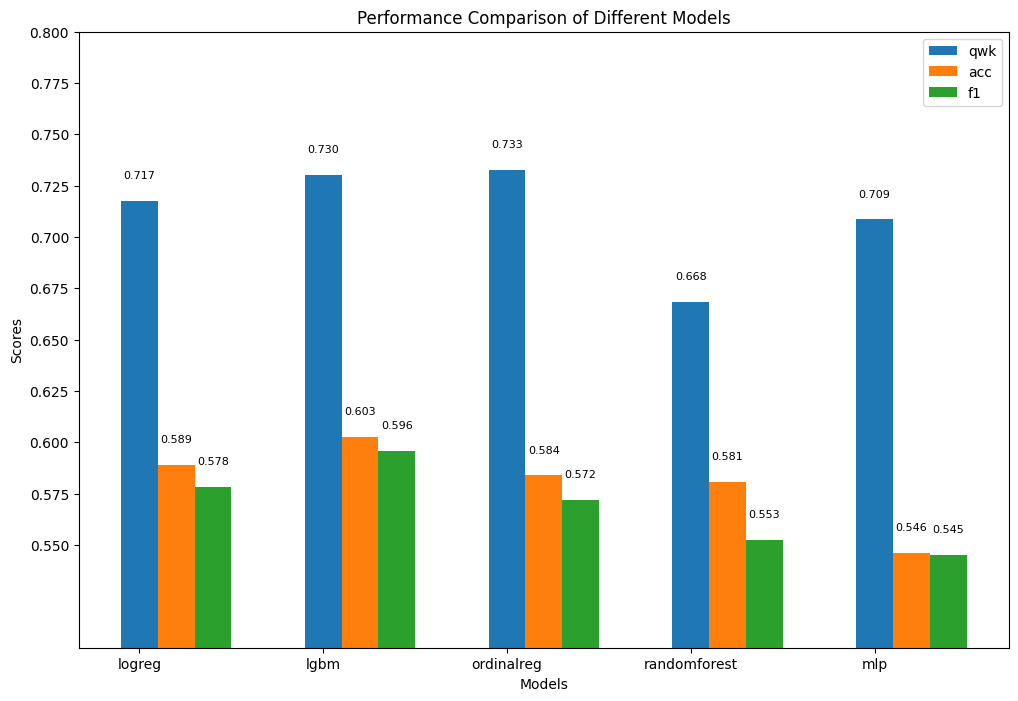

In [58]:
qwk_scores = [avg_logreg_qwk, avg_lgbm_qwk, avg_ordreg_qwk, avg_rf_qwk, avg_mlp_qwk]
acc_scores = [avg_logreg_acc, avg_lgbm_acc, avg_ordreg_acc, avg_rf_acc, avg_mlp_acc]
f1_scores = [avg_logreg_f1, avg_lgbm_f1, avg_ordreg_f1, avg_rf_f1, avg_mlp_f1]
model_names = ['logreg', 'lgbm', 'ordinalreg', 'randomforest', 'mlp']

plt.figure(figsize=(12, 8))

bar_width = 0.2

plt.bar([x for x in range(len(model_names))], qwk_scores, width=0.2, label='qwk')
plt.bar([x + bar_width for x in range(len(model_names))], acc_scores, width=0.2, label='acc')
plt.bar([x + bar_width + bar_width for x in range(len(model_names))], f1_scores, width=0.2, label='f1')



# Adding labels, title, and legend
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Performance Comparison of Different Models')
plt.ylim(0.5, 0.8) # this zoomes in the scale to make it easier to see
plt.xticks([x for x in range(len(model_names))], model_names)
plt.yticks([round(0.55 + 0.025 * i, 3) for i in range(11)]) # this makes the y axis show a better range of values

#  Annotate each bar with its value
for i, score in enumerate(qwk_scores):
    plt.text(i, score + 0.01, f'{score:.3f}', ha='center', va='bottom', color='black', fontsize=8)
for i, score in enumerate(acc_scores):
    plt.text(i + bar_width, score + 0.01, f'{score:.3f}', ha='center', va='bottom', color='black', fontsize=8)
for i, score in enumerate(f1_scores):
    plt.text(i + 2 * bar_width, score + 0.01, f'{score:.3f}', ha='center', va='bottom', color='black', fontsize=8)

plt.legend()

# Show plot
plt.show()

# ***Things to do:***

- put explanations and more markup in notebook

- more EDA, some diagrams and graphs on the dataset 

    ideas: - compare the cross validation qwk scores, group by scores and show word lengths etc

- try word2vec for vector embeddings and compare with tfidf - make w2v more accurate somehow

- find more models - potential: xgboostclassifier, ordinal logistic regression (sm), SGDClassifier? ,

- overall increase the performance of the models they arent predicting the test dataset 100% correctly

